In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

In [2]:
data_dir = "C:/Users/user/OneDrive/Masaüstü/dumpware10_images/dumpware10_images/300/300/TRAINING"

# Define transformations for your images (adjust as needed)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize for EfficientNet-B3
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Define the validation set split ratio (e.g., 20% for validation)
val_split = 0.2

# Split the dataset into train and validation sets using random_split
train_size = int(len(dataset) * (1 - val_split))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

image_datasets = {
    'train': train_data,
    'val': val_data,
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = dataset.classes

# ... rest of your transfer learning code using train_loader and val_loader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data = datasets.ImageFolder("C:/Users/user/OneDrive/Masaüstü/dumpware10_images/dumpware10_images/300/300/TEST", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, num_workers = 0)

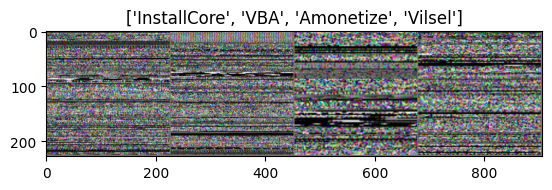

In [4]:
def imshow(inp, title=None):
    #Display image for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
writer = SummaryWriter("C:/Users/user/dumpefficientnetb5_sgd_001_11")

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == "train":
                writer.add_scalar("Training Loss", epoch_loss, epoch)
                writer.add_scalar("Training Accuracy", epoch_acc, epoch)
            elif phase == 'val':
                writer.add_scalar("Validation Loss", epoch_loss, epoch)
                writer.add_scalar("Validation Accuracy", epoch_acc, epoch)
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_ft = models.efficientnet_b5(weights='IMAGENET1K_V1')
num_ftrs =  model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9) #0.01

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=120)

Epoch 0/119
----------
train Loss: 1.8393 Acc: 0.4964
val Loss: 5.5710 Acc: 0.6870

Epoch 1/119
----------
train Loss: 1.0250 Acc: 0.6828
val Loss: 0.9258 Acc: 0.7540

Epoch 2/119
----------
train Loss: 0.8125 Acc: 0.7484
val Loss: 0.7985 Acc: 0.7496

Epoch 3/119
----------
train Loss: 0.7357 Acc: 0.7626
val Loss: 0.8204 Acc: 0.7409

Epoch 4/119
----------
train Loss: 0.6374 Acc: 0.7895
val Loss: 0.7602 Acc: 0.8035

Epoch 5/119
----------
train Loss: 0.5646 Acc: 0.8183
val Loss: 0.6342 Acc: 0.8253

Epoch 6/119
----------
train Loss: 0.5729 Acc: 0.8128
val Loss: 0.4821 Acc: 0.8515

Epoch 7/119
----------
train Loss: 0.4003 Acc: 0.8667
val Loss: 0.4443 Acc: 0.8632

Epoch 8/119
----------
train Loss: 0.3649 Acc: 0.8784
val Loss: 0.3928 Acc: 0.8734

Epoch 9/119
----------
train Loss: 0.3358 Acc: 0.8849
val Loss: 0.4053 Acc: 0.8763

Epoch 10/119
----------
train Loss: 0.3364 Acc: 0.8806
val Loss: 0.3612 Acc: 0.8675

Epoch 11/119
----------
train Loss: 0.3127 Acc: 0.8940
val Loss: 0.4188 Acc

In [9]:
torch.save(model_ft.state_dict(), "C:/Users/user/Documents/dumpefficientnetb5001sgdrgb.pt")

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

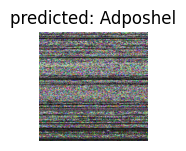

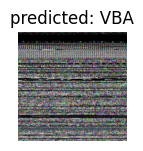

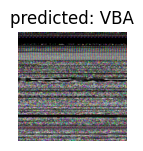

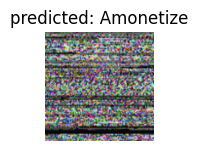

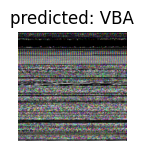

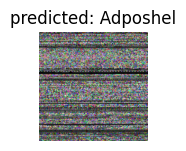

In [11]:
visualize_model(model_ft)

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the dump test images: {100 * correct // total} %')

Accuracy of the network on the dump test images: 89 %


Text(92.25, 0.5, 'True labels')

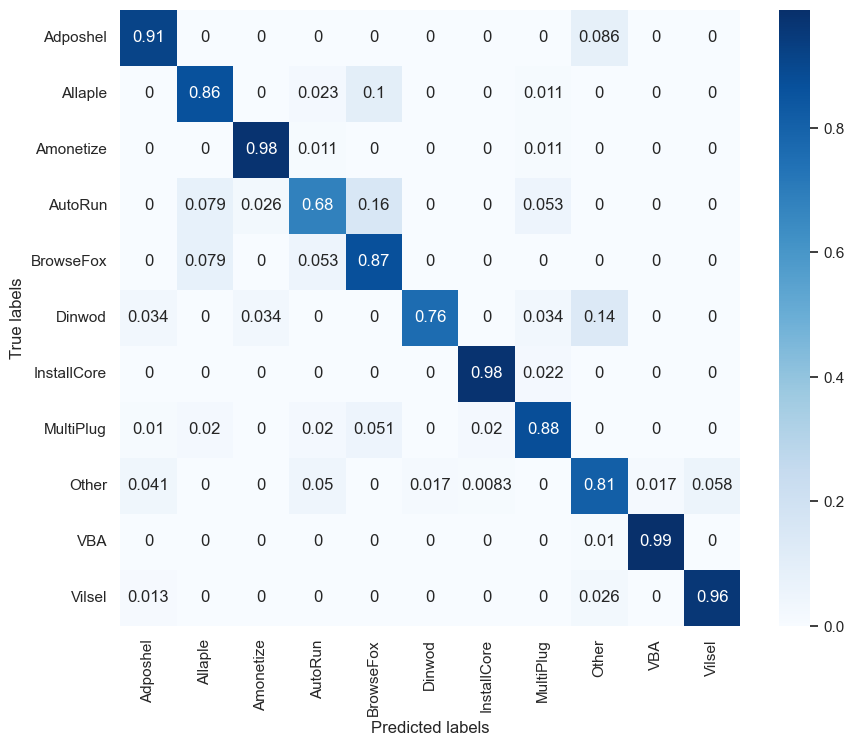

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = []
true_labels = []
label_names = ['Adposhel', 'Allaple', 'Amonetize', 'AutoRun', 'BrowseFox', 'Dinwod', 'InstallCore', 'MultiPlug', 'Other', 'VBA', 'Vilsel']
model_ft.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _,predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")